# **CT-Scan Model Training**
----

## 1. Import requires libraries

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import visualkeras

In [3]:
# Set random seed for reproducabiliy
np.random.seed(5)

## 2. Load data

The data we will use is sourced from [here](https://www.kaggle.com/datasets/plameneduardo/a-covid-multiclass-dataset-of-ct-scans) and was utilized in the paper [E. Soares, et. al (2020)](https://www.medrxiv.org/content/10.1101/2020.04.24.20078584v3). It contains a total of 4,173 scans from 210 different patients living in São Paolo, Brazil.

### Data ingestion

In [4]:
def load_ct_data(path):
    # Create datalist and error counter
    imported_data = []
    num_errors = 0
    
    # Loop through directory and sub-directories
    for directory in os.listdir(path):
        sub_path = path + "/" + directory
        
        if ".DS_Store" in sub_path:
            continue
    
        # Loop through all subdirectories
        for subdir in os.listdir(sub_path):
            subdir_path=sub_path + "/" + subdir
    
            if ".DS_Store" in subdir_path:
                continue
                
            # Loop through all images in subdirectory
            for img in os.listdir(subdir_path):
                # Get the image path
                image_path = subdir_path + "/" + img
                
                if ".DS_Store" in image_path:
                    continue
                
                # Load in the image
                img_arr = cv2.imread(image_path)
                # Try to resize it to the TARGET_IMAGE_SIZE variable
                try:
                    img_arr = cv2.resize(img_arr, TARGET_IMAGE_SIZE)
                    imported_data.append(img_arr)
                # If an exception occurs, omit it and continue
                except Exception as e:
                    num_errors += 1
                    continue

    return imported_data, num_errors

def load_xray_data(path):
    # Create datalist and error counter
    imported_data = []
    num_errors = 0
    
    for directory in os.listdir(path):
        sub_path = path + "/" + directory
        
        if ".DS_Store" in sub_path:
            continue
    
        # Loop through all subdirectories
        for image in os.listdir(sub_path):
            img_path = sub_path + "/" + image
    
            if ".DS_Store" in img_path:
                continue

            # Load in the image
            img_arr = cv2.imread(img_path)
            # Try to resize it to the TARGET_IMAGE_SIZE variable
            try:
                img_arr = cv2.resize(img_arr, TARGET_IMAGE_SIZE)
                imported_data.append(img_arr)
            # If an exception occurs, omit it and continue
            except Exception as e:
                num_errors += 1
                continue
            
    
    return imported_data, num_errors

In [5]:
choice = input("CT-Scan (ct) or X-Ray (xr) data?: ")

# X-RAY DATA
if choice == "xr":
    print("Loading X-Ray data...")
    path = "../data/raw/xray_data/"
    model_type = "xr"
    # We define the target image size as 256x256 pixels
    TARGET_IMAGE_SIZE = (128, 128)
    imported_data, num_errors = load_xray_data(path)
# CT-SCAN DATA
elif choice == "ct":
    print("Loading CT-Scan data...")
    path = "../data/raw/ct_data/"
    model_type = "ct"
    # We define the target image size as 100x100 pixels
    TARGET_IMAGE_SIZE = (100, 100)
    imported_data, num_errors = load_ct_data(path)
# INVALID SELECTION
else:
    print("Invalid selection, please try again")
    imported_data = []
    num_errors = 0
    model_type = ""
    
print(f"\tLoaded a total of {len(imported_data)} files.\nNum. Errors: {num_errors}")

CT-Scan (ct) or X-Ray (xr) data?:  xr


Loading X-Ray data...
	Loaded a total of 15153 files.
Num. Errors: 0


### Image preprocessing

Initially, each image was resized to be **128x128 pixels**.

Now we want to normalize the images to improve contrast in the colors. To do this, we divide all RGB pixel values by $255.0$.

In [6]:
images_norm = np.array(imported_data)

images_norm = images_norm / 255.0

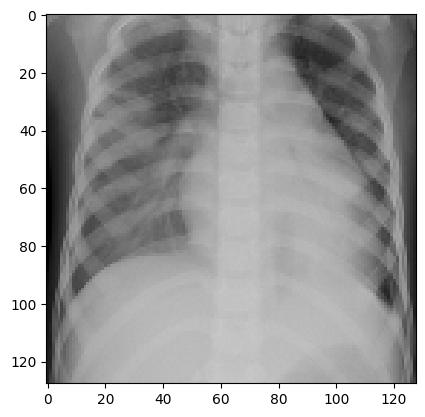

In [7]:
plt.imshow(images_norm[0], interpolation='nearest')
plt.show()

### Dataset labeling

This dataset contains three classifications for the included X-Ray images. The table below shows the sample sizes of these three categories contained in the dataset.

| ID |       Type      | Sample Size |
|:--:|:---------------:|:-----------:|
| 0  |     COVID-19    |   3,616     |
| 1  |     Healthy     |   10,192    |
| 2  | Viral Pneumonia |   1,345     |

As the data also includes a set of `Viral Pneumonia`, this model will also have the ability to make that classification.

To label these imaes, we use an `ImageDataGenerator` object to walk through the sub-directories of our data folder and capture the classes. We then combine these with the

In [8]:
data_generator = ImageDataGenerator(rescale = 1./255)
dataset_labels = data_generator.flow_from_directory(path,
                                                    target_size = TARGET_IMAGE_SIZE,
                                                    batch_size = 32,
                                                    class_mode = 'sparse')

# Get a list of the class labels from the ImageDataGenerator object
class_labels = dataset_labels.classes

print(f"\nIdentified Class Labels: {dataset_labels.class_indices}")

Found 15153 images belonging to 3 classes.

Identified Class Labels: {'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


## 3. Data split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(images_norm, class_labels, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.2)

print(f"Train Size (x, y): {x_train.shape[0],y_train.shape[0]}")
print(f"Validation Size (x, y): {x_val.shape[0],y_val.shape[0]}")
print(f"Test Size (x, y): {x_test.shape[0],y_test.shape[0]}")

Train Size (x, y): (10909, 10909)
Validation Size (x, y): (2728, 2728)
Test Size (x, y): (1516, 1516)


## 4. Model configuration

We used a CNN with **N** layers to accomplish this classification task.

**[INSERT IMAGE OF LAYERS HERE]**

**Model Type:** Sequential (linear model)

**Layer Breakdown:**

- _**Convolution Layer:**_ The convolution layers use the sliding window approach to look at the pixels in each input image to identify patterns/features within. All such layers used here use the `relu` activation function.
- _**Pooling Layer:**_ These layers reduce the spatial dimensions of the data by taking the maximum value from each 2x2 px region of the previous layer's output. It helps boost efficiency.
- _**Batch Normalization**_ These layers standardize the output of the pooling layer to assit in stabilizing and accelerating the training process.
- _**Flatten Layer:**_ After the last pooling layer, this layer converts the 2D output (e.g. x and y points) into a 1D array to prepare the data for the final output layer.
- _**Output Layer:**_ The output layer has 3 neurons and is activated with `softmax` which converts the raw predictions into the probabilities of each class, the highest of which is our final output.

In [10]:
# Create the model as a sequential CNN
model = Sequential()

# FIRST LAYER GROUP (INPUT)
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(TARGET_IMAGE_SIZE[0],
                                                         TARGET_IMAGE_SIZE[1],
                                                         3)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# SECOND LAYER GROUP
model.add(Conv2D(32,(12, 12),activation='relu'))
# model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# THIRD LAYER GROUP
model.add(Conv2D(64,(6, 6),activation='relu'))
# model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# FOURTH LAYER GROUP
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# FIFTH LAYER GROUP
model.add(Flatten())

# SIXTH LAYER GROUP (OUTPUT)
model.add(Dense(3,activation='softmax'))

### Model summary

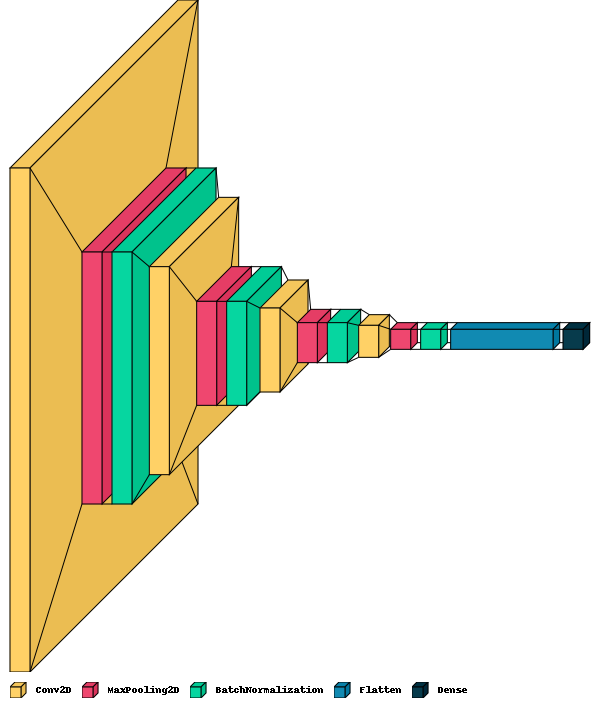

In [11]:
# Visualize the model
visualkeras.layered_view(model, legend=True)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 52, 32)        147488    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 32)        0         
 g2D)                                                            
                                                        

## 5. Model training

To train the model, we will use an [adam](https://keras.io/api/optimizers/adam/#:~:text=Adam%20optimization%20is%20a%20stochastic,order%20and%20second%2Dorder%20moments.) optimizer and will enable early-stopping.

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=7,
                           restore_best_weights=True)

# Train the model
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val, y_val),
                    epochs=30,
                    callbacks=[early_stop],
                    shuffle=True)

epoch = history.epoch[-1]

Epoch 1/30
 49/341 [===>..........................] - ETA: 1:11 - loss: 0.9170 - accuracy: 0.6671

KeyboardInterrupt: 

### Training evaluation

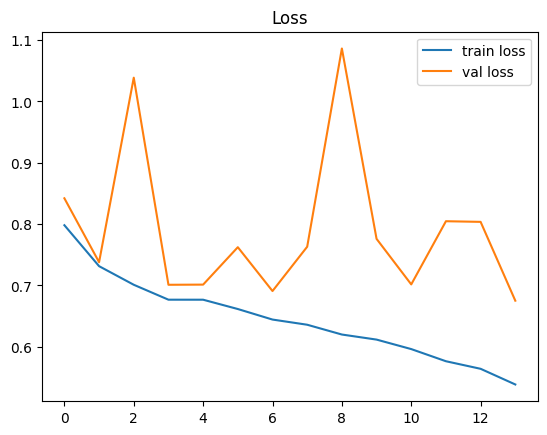

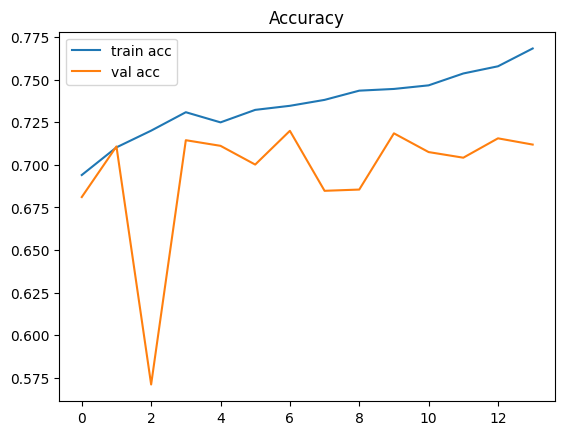

In [67]:
# Loss and accuracy graph
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

48/48 [==============================] - 3s 61ms/step
              precision    recall  f1-score   support

COVID-19 (0)       0.38      0.75      0.50       177
 Healthy (1)       0.90      0.75      0.82      1257
   Other (2)       0.21      0.30      0.25        82

    accuracy                           0.73      1516
   macro avg       0.50      0.60      0.52      1516
weighted avg       0.80      0.73      0.75      1516



<Axes: >

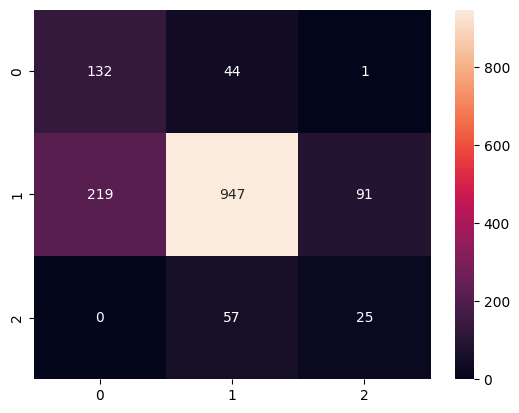

In [68]:
# Create confusion matrix
categories = ["COVID-19 (0)", "Healthy (1)", "Other (2)"]
y_test_pred = model.predict(x_test) # Calculate confusion matrix on test data
y_test_pred = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test_pred,y_test,target_names=categories))
sns.heatmap(confusion_matrix(y_test_pred, y_test), annot=True, fmt=',d')

In [69]:
if input("Save model (y/n): ").lower() == "y":
    out_name = input("\tModel Name: ")
    model.save(f'../models/{out_name}.h5')
    print("\tModel saved!")
else:
    print("\tModel not saved!")

Save model (y/n):  y
	Model Name:  cnn-xr-73


	Model saved!


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
